In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import random
import numpy as np
import gc
import math

TOTAL_DATA_POINTS = 200
N_HIDDEN = 512
RESHAPED = 2
NB_CLASSES = 4
DROPOUT = 0.3
BATCH_SIZE = 15
EPOCHS = 50
VERBOSE = 1
VALIDATION_SPLIT = 0.25
TOTAL_ITEMS = 8
EMBEDDINGS = 8

def get_dataset():
    rng = tf.random.Generator.from_seed(seed=234)
    randomNumbers = rng.truncated_normal(shape=[TOTAL_DATA_POINTS], mean=0.5, stddev=.05)
    return randomNumbers

random_dataset = get_dataset()

def get_random_numbers():
    randomNumbers = []
    for i in range(0, TOTAL_DATA_POINTS):
        randomNumbers.append(random.random())
    return randomNumbers

random_dataset = get_dataset()

random_numbers = get_random_numbers()

def convert_to_train_test_data(random_dataset, random_numbers, test_percent = 0.15):
    total_independent = []
    total_dependent = []
    
    for i in range(0, TOTAL_DATA_POINTS):
        index = getIndex(random_numbers[i])
        total_dependent.append(getArrayFromIndex(index))
    
    count = 0
    for i in total_dependent:
        index = getIndexFromArray(i)
        total_independent.append([getIndex(random_dataset[count].numpy() / index) - 1, getIndex(random_dataset[count].numpy() + .1 / (index + 1))])
        #total_independent.append(getIndex(random_dataset[count].numpy()) - 1)
        count = count + 1
            
    testRecordCount = int(round(test_percent*len(total_independent)))
    return total_independent[testRecordCount:], total_dependent[testRecordCount:], total_independent[:testRecordCount], total_dependent[:testRecordCount]
    
def getIndex(chance):
    return math.ceil(chance * TOTAL_ITEMS)

def getIndexFromArray(array):
    return np.where(array == np.amax(array))[0][0] + 1


def getArrayFromIndex(index):
    return [1 if index == 1 else 0, 1 if index == 2 else 0, 1 if index == 3 else 0, 1 if index == 4 else 0]

def createModel(lossFunction):

    model = tf.keras.models.Sequential()
    model.add(keras.layers.Input(shape=(RESHAPED,)))
    model.add(keras.layers.Embedding(EMBEDDINGS, N_HIDDEN, input_length=RESHAPED, ))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(N_HIDDEN, name='hidden_dense_layer', activation='relu'))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Activation(activation='selu'))
    model.add(keras.layers.Dense(NB_CLASSES, activation='softmax', name='output_dense_layer'))
    model.compile(optimizer='adam', loss=lossFunction, metrics=['accuracy'])
    
    return model

def displayResults(history):
    train_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs = range(1, len(validation_loss)+1)

    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(epochs, train_loss, label='train loss')
    ax.plot(epochs, validation_loss, label='validation loss')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('loss')  # Add a y-label to the axes.
    ax.set_title("Simple Plot")  # Add a title to the axes.
    ax.legend() 

def showPrediction(model, x_train, y_train, x_test, y_test):

    INDEX_1 = 0
    INDEX_2 = 1
    TRAINING_X_1 = []
    TRAINING_X_2 = []
    TRAINING_Y = []
    TEST_X_1 = []
    TEST_X_2 = []
    TEST_Y = []
    PREDICTED_INDEPENDANT_1 = []
    PREDICTED_INDEPENDANT_2 = []
    PREDICTED_DEPENDANT = []

    count = 0
    for p in y_train:
        TRAINING_X_1.append(x_train[count][INDEX_1])
        TRAINING_X_2.append(x_train[count][INDEX_2])
        TRAINING_Y.append(getIndexFromArray(y_train[count]))
        count += 1
        
    count = 0
    for p in y_test:
        TEST_X_1.append(x_test[count][INDEX_1])
        TEST_X_2.append(x_test[count][INDEX_2])
        TEST_Y.append(getIndexFromArray(y_test[count]))
        count += 1
    
    pred_traning = model.predict(np.array(x_train))

    count = 0
    for p in pred_traning:
        PREDICTED_INDEPENDANT_1.append(x_train[count][INDEX_1])
        PREDICTED_INDEPENDANT_2.append(x_train[count][INDEX_2])
        PREDICTED_DEPENDANT.append(getIndexFromArray(p))
        count += 1

    pred_validation = model.predict(np.array(x_test))

    count = 0
    for p in pred_validation:
        PREDICTED_INDEPENDANT_1.append(x_test[count][INDEX_1])
        PREDICTED_INDEPENDANT_2.append(x_test[count][INDEX_2])
        PREDICTED_DEPENDANT.append(getIndexFromArray(p))
        count += 1

    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(TRAINING_X_1, TRAINING_Y, label='training data', linewidth=0, marker='.')
    ax.plot(TEST_X_1, TEST_Y, label='test data', linewidth=0, marker='.')
    ax.set_xlabel('independent')  # Add an x-label to the axes.
    ax.set_ylabel('dependant')  # Add a y-label to the axes.
    ax.legend() 
    
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(PREDICTED_INDEPENDANT_1, PREDICTED_DEPENDANT, label='prediction values', linewidth=0, marker='.')
    ax.set_xlabel('independent')  # Add an x-label to the axes.
    ax.set_ylabel('dependant')  # Add a y-label to the axes.
    ax.legend() 
    
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(TRAINING_X_2, TRAINING_Y, label='training data', linewidth=0, marker='.')
    ax.plot(TEST_X_2, TEST_Y, label='test data', linewidth=0, marker='.')
    ax.set_xlabel('independent')  # Add an x-label to the axes.
    ax.set_ylabel('dependant')  # Add a y-label to the axes.
    ax.legend() 
    
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(PREDICTED_INDEPENDANT_2, PREDICTED_DEPENDANT, label='prediction values', linewidth=0, marker='.')
    ax.set_xlabel('independent')  # Add an x-label to the axes.
    ax.set_ylabel('dependant')  # Add a y-label to the axes.
    ax.legend() 

print('done')

done


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 512)            4096      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               295424    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
hidden_dense_layer (Dense)   (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
output_dense_layer (Dense)   (None, 4)                 2

1/1 [==============================] - 0s 964us/step - loss: 0.2588 - accuracy: 0.9000

Test accuracy: 0.8999999761581421


4226

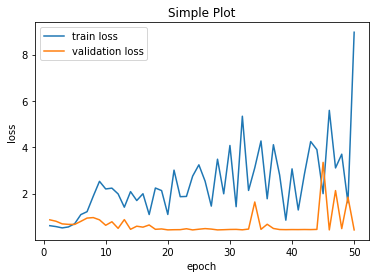

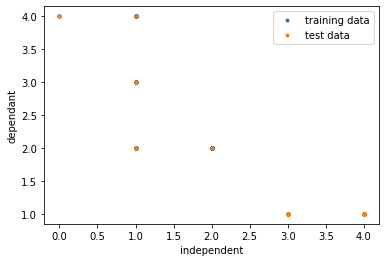

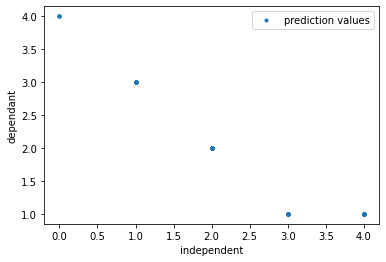

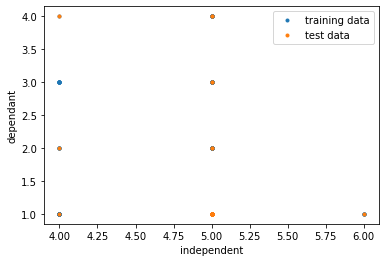

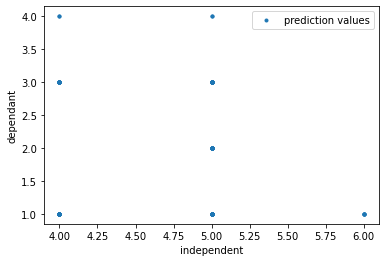

In [2]:
tf.random.set_seed(1234)
np.random.seed(0)
tf.random.shuffle(tf.range(5))
    
x_train, y_train, x_test, y_test = convert_to_train_test_data(random_dataset, random_numbers, test_percent=0.15)

model = createModel('categorical_crossentropy')

model.summary()

history = model.fit(np.array(x_train), np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

test_loss, test_acc = model.evaluate(np.array(x_test), np.array(y_test))
print()
print('Test accuracy:', test_acc)

displayResults(history)

showPrediction(model, x_train, y_train, x_test, y_test)

del model
tf.keras.backend.clear_session()

gc.collect()